In [ ]:
# ===============================================
# Aplikace natrénovaného sentimentového modelu
# Autor: Radka Fojtová
# Popis: Notebook načítá texty z rozhovorů, analyzuje jejich sentiment
# a třídí je do kategorií (pozitivní / neutrální / negativní).
# Věty jsou uloženy do příslušných složek a zároveň je vytvořen
# výstupní soubor, který obsahuje ke každé větě její třídu a míru jistoty predikce.
#
# V závěru notebooku je navíc zobrazen přehled:
# – počet vět v každé třídě,
# – grafické porovnání výsledků podle jednotlivých souborů,
# – zkoumání různých prahových hodnot pro lepší interpretaci výsledků.
# ===============================================

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F


Mounted at /content/drive


In [ ]:
#Nastavení cesty k natrénovanému modelu
model_path = "vaše_cesta_k_modelu"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(51997, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
# Nastavení cesty k textům, které chcete analyzovat
base_path = "vaše_cesta_k_textům"
input_folder = os.path.join(base_path, "vstupní_složka")
output_folder = os.path.join(base_path, "label+confidence")
categories = {
    "pozitivní": os.path.join(base_path, "Pozitivní_věty"),
    "negativní": os.path.join(base_path, "Negativní_věty"),
    "neutrální": os.path.join(base_path, "Neutrální_věty")
}

# Vytvoření složek pro výstup
os.makedirs(output_folder, exist_ok=True)
for path in categories.values():
    os.makedirs(path, exist_ok=True)


In [ ]:
# Funkce pro analýzu sentimentu
label_map = {0: "negativní", 1: "neutrální", 2: "pozitivní"}

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred].item()
    return label_map[pred], round(confidence, 4)


In [ ]:
for filename in os.listdir(input_folder):
    if not filename.endswith(".txt"):
        continue

    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename)

    with open(input_path, "r", encoding="utf-8") as f:
        lines = [line.strip() for line in f if line.strip()]

    # Výstup 1: soubor s labely+confidence
    result_lines = []

    # Výstupy 2: věty podle kategorií
    separated = {
        "pozitivní": [],
        "negativní": [],
        "neutrální": []
    }

    for line in lines:
        label, confidence = predict_sentiment(line)
        result_lines.append(f"{label},{confidence}")
        separated[label].append(line)

    # Uložení výsledků do složky
    with open(output_path, "w", encoding="utf-8") as out:
        out.write("\n".join(result_lines))

    # Uložení vět podle kategorií
    for cat, path in categories.items():
        with open(os.path.join(path, filename), "w", encoding="utf-8") as out_cat:
            out_cat.write("\n".join(separated[cat]))


In [ ]:
import os
import pandas as pd

# Cesta ke složce s výstupy
analyza_path = "vaše_cesta_k_výsledkům(label+confidence)"

# Načti všechny soubory ze složky
soubor_list = sorted([f for f in os.listdir(analyza_path) if f.endswith('.txt')])


In [ ]:
# Celkový přehled - počet vět v každé třídě
from collections import Counter

celkove_vysledky = Counter()

for file in soubor_list:
    with open(os.path.join(analyza_path, file), encoding="utf-8") as f:
        for line in f:
            label = line.strip().split(',')[0]
            celkove_vysledky[label] += 1

print("Celkový přehled:")
for k, v in celkove_vysledky.items():
    print(f"{k}: {v}")


Celkový přehled:
neutrální: 1584
pozitivní: 241
negativní: 734


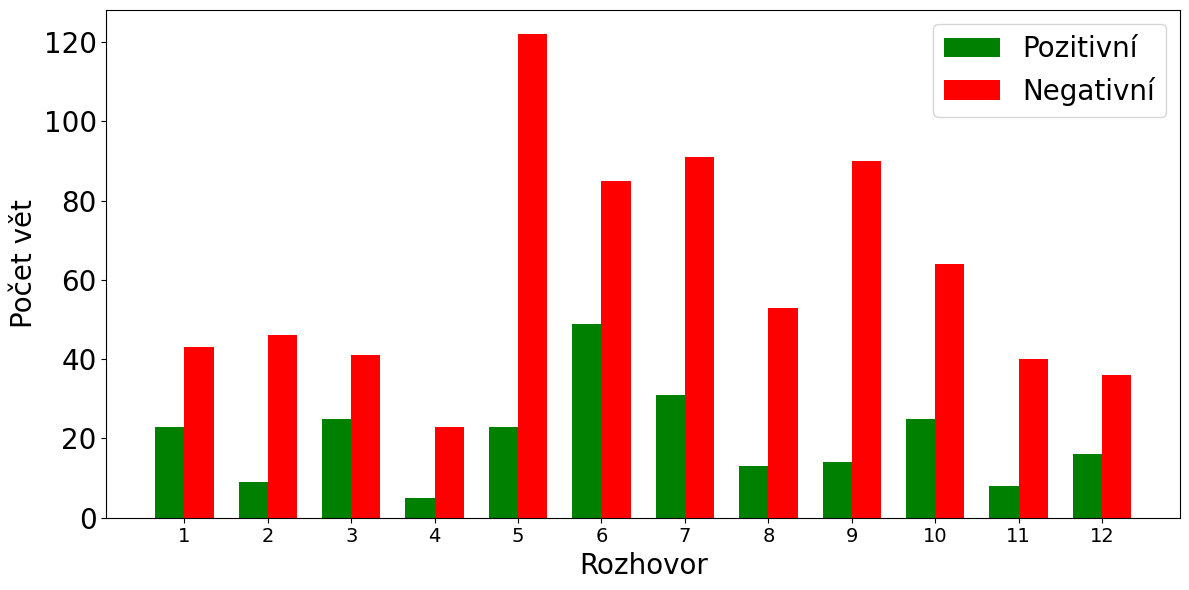

In [ ]:
# Vykreslení grafu - počet pozitivních a negativních vět pro každý soubor
import os
import matplotlib.pyplot as plt
import re

# Cesta ke složce s výsledky analýzy
analyza_path = "vaše_cesta_k_label+confidence"

# Slovníky pro počty
counts = {}

# Získání čísel a načtení dat
for filename in os.listdir(analyza_path):
    if filename.endswith(".txt"):
        match = re.search(r"\d+", filename)
        if match:
            cislo = int(match.group())
            pozitivni = 0
            negativni = 0
            with open(os.path.join(analyza_path, filename), "r", encoding="utf-8") as f:
                for line in f:
                    if line.startswith("pozitivní"):
                        pozitivni += 1
                    elif line.startswith("negativní"):
                        negativni += 1
            counts[cislo] = (pozitivni, negativni)

# Vytvoření grafu
label+confidence = sorted(counts.keys())
pozitivni_data = [counts[i][0] for i in label+confidence]
negativni_data = [counts[i][1] for i in label+confidence]

x = range(len(label+confidence))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x, pozitivni_data, width=width, label="Pozitivní", color="green")
plt.bar([i + width for i in x], negativni_data, width=width, label="Negativní", color="red")

plt.xlabel("Rozhovor", fontsize=20)
plt.ylabel("Počet vět", fontsize=20)

plt.xticks([i + width / 2 for i in x], [str(i) for i in label+confidence], rotation=0, fontsize=14)
plt.yticks(fontsize=20)

plt.legend(fontsize=20)
plt.tight_layout()

# Uložení
plt.savefig("vaše_cesta_ke_grafu", dpi=600)
plt.show()


In [ ]:
# Thresholds
import os
import pandas as pd

# Cesta ke složce
folder_path = "vaše_cesta_label+confidence"

# Prahové hodnoty a kategorie
thresholds = [0.5, 0.8, 0.9]
categories = ["pozitivní", "negativní", "neutrální"]

# Inicializace
counts = {cat: 0 for cat in categories}
above_threshold = {cat: [0]*len(thresholds) for cat in categories}

# Procházení souborů
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        with open(os.path.join(folder_path, filename), "r", encoding="utf-8") as f:
            for line in f:
                parts = line.strip().split(",")
                if len(parts) != 2:
                    continue
                label, score_str = parts
                score = float(score_str)
                if label not in categories:
                    continue
                counts[label] += 1
                for i, t in enumerate(thresholds):
                    if score > t:
                        above_threshold[label][i] += 1

# Převod do DataFrame
df = pd.DataFrame({
    "Třída": categories,
    "> 0.5": [f"{above_threshold[cat][0] / counts[cat] * 100:.1f} %" if counts[cat] > 0 else "0 %" for cat in categories],
    "> 0.8": [f"{above_threshold[cat][1] / counts[cat] * 100:.1f} %" if counts[cat] > 0 else "0 %" for cat in categories],
    "> 0.9": [f"{above_threshold[cat][2] / counts[cat] * 100:.1f} %" if counts[cat] > 0 else "0 %" for cat in categories],
})

# Uložení + výpis
df.to_csv("vaše_cesta_k_tabulce", index=False)
df



,Třída,> 0.5,> 0.8,> 0.9
0,pozitivní,91.3 %,53.2 %,33.5 %
1,negativní,96.3 %,45.5 %,26.1 %
2,neutrální,96.0 %,50.4 %,27.7 %
